In [1]:
import cv2
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt


import habitat
from habitat.sims.habitat_simulator.actions import HabitatSimActions

from common import environments
import common.default_blocks as db
from agents.kozub_agent import BlockAgent
import matplotlib.pyplot as plt
from common.baseline_registry import baseline_registry
from config.default import get_config

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
# set keystroke constant
F, L, R, S=  "w", "a", "d", "f"
class keybord_agent():
    def __init__(self):
        pass
    def reset(self):
        pass
    def act(self, *args):
        not_valid_key = True
        while not_valid_key:
            not_valid_key = False
            print('waitkEY')
            keystroke = cv2.waitKey(0)

            if keystroke == ord(F):
                action = HabitatSimActions.MOVE_FORWARD
                #agent.set_last_action((action - 1) % 4)
                print("action: FORWARD")
            elif keystroke == ord(L):
                action = HabitatSimActions.TURN_LEFT
                #agent.set_last_action((action - 1) % 4)
                print("action: LEFT")
            elif keystroke == ord(R):
                action = HabitatSimActions.TURN_RIGHT
                #agent.set_last_action((action - 1) % 4)
                print("action: RIGHT")
            elif keystroke == ord(S):
                action = HabitatSimActions.STOP
                #agent.setlast_action((action - 1) % 4)
                print("action: FINISH")
            else:
                not_valid_key = True
                print("INVALID KEY")
        return {'action' : action-1}

In [3]:
def show_rgb(image, cv):
    if cv:
        cv2.imshow("RGB", transform_rgb_bgr(image))
    else:
        plt.imshow(image)
        plt.plot()
        time.sleep(1)

def show_rgb(image, cv):
    if cv:
        cv2.imshow("RGB", transform_rgb_bgr(image))
    else:
        plt.imshow(image)
        plt.plot()
        time.sleep(1)

def transform_rgb_bgr(imsage):
    return image[:, :, [2, 1, 0]]

In [4]:
def main(episodes = 1, steps = 50, env_name = 'NavRLEnv', keybord_control = False, 
         show_step_info = False, show_episode_info = False,
         rgb = False, cv_rgb = False, cv_control = False):

    if env_name == 'NavRLEnv':
        config = get_config("./config/pointnav/test_agent_pointnav.yaml")
        config.defrost()
        config.TASK_CONFIG.DATASET.DATA_PATH = "/habitat-api/data/datasets/pointnav/gibson/v1/val/val.json.gz"
        config.RL.SUCCESS_REWARD = 10
        
        config.SENSORS = ['RGB_SENSOR']
        config.TASK_CONFIG.PYROBOT.SENSORS = ['RGB_SENSOR']
        config.TASK_CONFIG.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR']
        
        #set model path
        config.AGENT.MODEL_PATH = "./LP_weights.pth"     
        config.freeze()
    else:
        config = get_config("./config/pointnav/train_LP_pointnav.yaml")
        config.defrost()
        config.TASK_CONFIG.DATASET.DATA_PATH="/habitat-api/data/datasets/pointnav/gibson/v1/train/content/Azusa.json.gz"
        config.RL.SUCCESS_REWARD = 1
        config.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ['MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT']
        config.freeze()

    # Agent:
    if keybord_control:
        agent = keybord_agent()
    else:
        agent = BlockAgent(config)
    # Environment:
    env = baseline_registry.get_env(config.ENV_NAME)(config=config)
    
    #Main Cycle
    spls = []
    for i in range(episodes):
        observation = env.reset()
        count_steps = 0
        agent.reset()
        if show_step_info:
            print("Agent stepping around inside environment.")
            print("Destination, distance: {:3f}, theta(radians): {:.2f}".format(
                observation['pointgoal_with_gps_compass'][0], observation['pointgoal_with_gps_compass'][1]))

        if rgb or keybord_control:
            show_rgb(observation['rgb'], cv_rgb)

        action = None
        done = False
        while not action == HabitatSimActions.STOP\
                and count_steps < steps and not done:

            action = agent.act(env, observation)

            observation, reward, done, info = env.step(**action)
            count_steps += 1

            if rgb or keybord_control:
                show_rgb(observation['rgb'], cv_rgb)
            if show_step_info:
                print('agent chose action:', action)
                print("Destination, distance: {:3f}, theta(radians): {:.2f}, reward: {:.2f}".format(
                    observation['pointgoal_with_gps_compass'][0], observation['pointgoal_with_gps_compass'][1], reward))

                
        spls.append(info['spl'])
        
        if show_episode_info:
            print("Episode finished after {} steps.".format(count_steps))
            if action['action'] == HabitatSimActions.STOP and observation['pointgoal_with_gps_compass'][0] < 0.2:
                print("you successfully navigated to destination point with spl: ", info)
            else:
                print("your navigation was unsuccessful")
                
    clear_output()
    plt.plot(spls, label='spl')
    plt.legend()
    plt.plot()
    print('mean spl: ', np.mean(spls))
    env.close()

mean spl:  0.7801142927096438


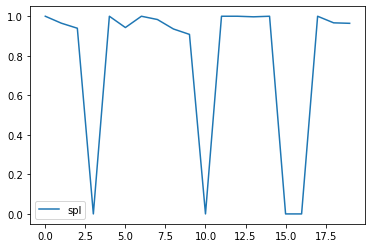

In [5]:
if __name__ == "__main__":
    obs = main(episodes = 20, 
               steps = 500, 
               env_name = 'NavRLEnv',
               keybord_control=False, 
               show_step_info = False, 
               show_episode_info = True,
               rgb = False, 
               cv_rgb = True, 
               cv_control = True)